In [920]:
%matplotlib inline

import os
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import datetime
import numpy
from pandas.plotting import table 

In [921]:
basic_colors = [
    'b',
'g',
'r',
'c',
'm',
'y',
'k',
'w'
]
colors = [
    'black',
    'rosybrown',
    'brown',
    'red',
    'orangered',
    'lightsalmon',
    'peru',
    'gold',
    'olive',
    'lawngreen',
    'darkgreen',
    'turquoise',
    'teal',
    'slategrey',
    'royalblue',
    'indigo',
    'purple',
    'deeppink'
]

In [922]:
def getDT(dt):
    if isinstance(dt, str):
        return dt
    return dt.strftime("%-m/%-d/%y")
def toDT(dt):
    if not isinstance(dt, str):
        return dt
    return datetime.datetime.strptime(dt, "%m/%d/%y")

In [923]:
def getFormattedDfFromTimeSeries(path):
    df = pd.read_csv(path)
    df = df.drop('Lat', 1).drop('Long', 1).drop('Province/State',1)
    df = df.groupby('Country/Region').sum().sort_values(by=df.columns[-1], ascending=False).T
    if 'Cruise Ship' in df.columns:
        df = df.drop('Cruise Ship', 1)
    sortedDf = df.T.sort_values(by=df.T.columns[-1], ascending=False).T
    return sortedDf, pd.read_csv(path).drop('Lat', 1).drop('Long', 1)

In [924]:
careBeds = pd.read_csv("~/Downloads/CareBeds.csv") 
# https://link.springer.com/article/10.1007/s00134-012-2627-8/tables/2

In [925]:
population = pd.read_csv('~/Downloads/PopulationByCountry.csv')
population['Population'] = population['Population'].str.replace(",","").astype(int)
population.loc[population['Name'] == 'United States','Name'] = 'US'
# population.loc[population['Name'] == 'United Kingdom','Name'] = 'UK'

In [926]:
def get_all_data():
    basepath = '../csse_covid_19_data/csse_covid_19_daily_reports/'
    files = filter(lambda x: 'csv' in x, os.listdir(basepath))
    dfs = map(lambda x: pd.read_csv(os.path.join(basepath, x)), files)
    dfs = list(dfs)
    df = pd.concat(dfs, sort=False)
    untransformed = df.copy()
    old_new_cols = {
        'Province/State': 'Province_State',
        'Country/Region': 'Country_Region',
        'Last Update': 'Last_Update',
    }
    for old_col, new_col in old_new_cols.items():
        df[new_col] = df[new_col].fillna(df[old_col])
        df = df.drop(old_col, 1)
    cols_to_drop = ['Lat', 'Long_', 'Latitude', 'Longitude', 'FIPS', 'Admin2']
    for col in cols_to_drop:
        df = df.drop(col, 1)
    df['Last_Update'] = pd.to_datetime(df['Last_Update'])
    untransformed['Last_Update'] = pd.to_datetime(untransformed['Last_Update'])
    df = df.set_index('Last_Update')
    for col in ['Confirmed', 'Deaths', 'Recovered']:
        df[col] = df[col].fillna(0)
#     df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
    df['Province_State'] = df['Province_State'].fillna("All")
    return df.sort_index(), untransformed

In [927]:
all_data, untransformed = get_all_data()

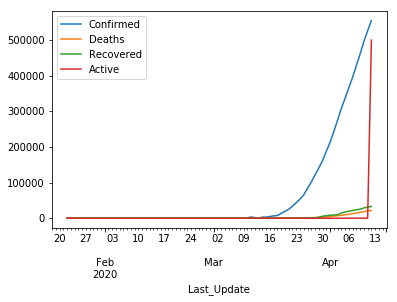

In [928]:
all_us_data = all_data[all_data['Country_Region'] == 'US']
grouped_data = all_us_data.drop('Province_State', 1).drop('Country_Region', 1).reset_index().resample('D', on='Last_Update').sum()
grouped_data.plot()


In [929]:
def getStateData(df, stateName):
    return df[df['Province_State'] == stateName].reset_index().resample('D', on='Last_Update').sum().dropna()


In [930]:
def get_nyc_data(typeOfSummary):
    df = pd.read_csv('../self_data/nyc_{}.csv'.format(typeOfSummary), index_col=[0,1,2])
    return df.sort_index().reset_index().set_index('dt')

In [931]:
nyc_data_confirmed = get_nyc_data('confirmed')
nyc_data_death = get_nyc_data('deaths')
nyc_data_death['first'] = nyc_data_death['first'].fillna('Age Group')
nyc_data_death = nyc_data_death.iloc[16:]
nyc_data_hospitalized = get_nyc_data('hospitalizations')
nyc_data_hospitalized['first'] = nyc_data_hospitalized['first'].fillna('Age Group')
nyc_all_data = pd.merge(nyc_data_death.reset_index(), nyc_data_hospitalized.reset_index(),  how='left', left_on=['dt','first','second'], right_on = ['dt','first','second']).set_index('dt')
nyc_age_data = nyc_all_data[nyc_all_data['first'] == 'Age Group'].drop('first',1)
nyc_age_data = nyc_age_data.drop('Total', 1)

nyc_data_confirmed.index = pd.to_datetime(nyc_data_confirmed.index)
nyc_data_death.index = pd.to_datetime(nyc_data_death.index)
nyc_data_hospitalized.index = pd.to_datetime(nyc_data_hospitalized.index)
nyc_age_data.index = pd.to_datetime(nyc_age_data.index)

In [932]:
nyc_total_cases = nyc_data_confirmed.reset_index().groupby(['dt','first']).sum().reset_index().groupby(['dt']).max()[['Total Cases']]

nyc_delta = nyc_total_cases.diff().iloc[2:]


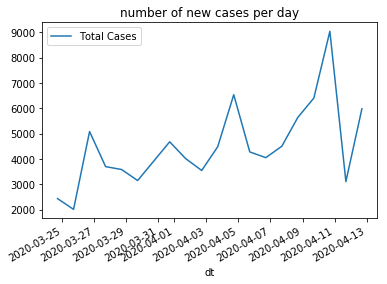

In [933]:
nyc_delta.plot()
plt.title('number of new cases per day')
plt.savefig('nyc.newcases.png')

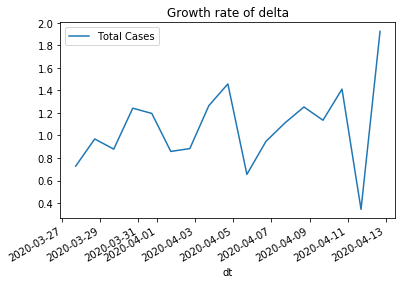

In [934]:
ax = (nyc_delta.iloc[2:] / nyc_delta.iloc[2:].shift()).iloc[1:].plot()
plt.title('Growth rate of delta')
plt.savefig('nyc.delta.growth.png')

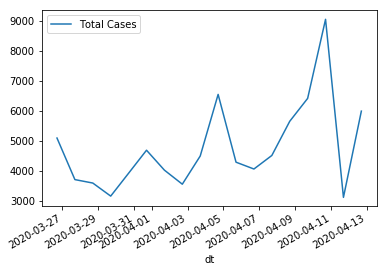

In [935]:
nyc_delta.iloc[2:].plot()

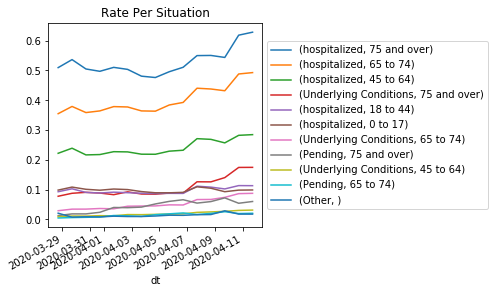

In [936]:
grouped = nyc_age_data.reset_index().groupby(['dt','second']).sum().unstack().fillna(0)
divgroup = grouped.div(grouped['confirmed'], axis=0).fillna(0)
plottingDf = divgroup.iloc[:-1].drop('confirmed', 1)
plottingDf = plottingDf.T.sort_values(by=plottingDf.index[-1],ascending=False).iloc[:10].T
plottingDf['Other'] = divgroup.drop('confirmed', 1).sum(axis=1) - plottingDf.sum(axis=1)
plottingDf[plottingDf < 0] = 0
ax = plottingDf.plot()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.title("Rate Per Situation")
plt.savefig('rate.per.situation.png')

success
dt                                    2020-03-28 17:00:00  2020-04-11 17:00:00
                         second                                               
Underlying Conditions    0 to 17                 0.000000             0.155602
                         18 to 44                0.121093             0.549756
                         45 to 64                0.896565             3.100492
                         65 to 74                2.884346             8.726949
                         75 and over             7.745962            17.451344
                         Unknown                 0.000000             0.000000
No Underlying Conditions 0 to 17                 0.000000             0.000000
                         18 to 44                0.015137             0.060790
                         45 to 64                0.066063             0.134926
                         65 to 74                0.028003             0.145584
                         75 and over        

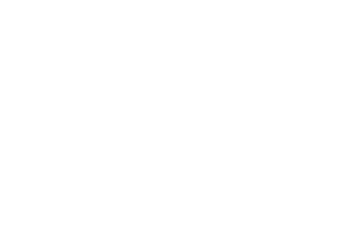

In [937]:
df_to_table = (divgroup.iloc[:-1].drop('confirmed', 1).iloc[[0, -1]] * 100).T
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tableToPlot = df_to_table
tableToPlot.to_html('table.tmp.html')
title = """<h3>NYC Rate Of Different Conditions</h3>"""
with open('table.tmp.html', 'r') as f:
    with open('table.html', 'w') as f2:
        f2.write(title + "\n")
        f2.write(f.read())
import subprocess
output = subprocess.call(
    'wkhtmltoimage -f png --width 0 table.html table.nyc.rate.wkh.png', shell=True)

if output != 0:
    print("Try installing wkhtmltoimage/pdf: brew cask install wkhtmltopdf")
else:
    subprocess.call('rm *.html', shell=True)
    print("success")
    print(tableToPlot[:25])

In [938]:
df_to_table

dt                                    2020-03-28 17:00:00  2020-04-11 17:00:00
                         second                                               
Underlying Conditions    0 to 17                 0.000000             0.155602
                         18 to 44                0.121093             0.549756
                         45 to 64                0.896565             3.100492
                         65 to 74                2.884346             8.726949
                         75 and over             7.745962            17.451344
                         Unknown                 0.000000             0.000000
No Underlying Conditions 0 to 17                 0.000000             0.000000
                         18 to 44                0.015137             0.060790
                         45 to 64                0.066063             0.134926
                         65 to 74                0.028003             0.145584
                         75 and over             0.146843             0.194625
                         Unknown                 0.000000             0.000000
Pending                  0 to 17                 0.000000             0.000000
                         18 to 44                0.030273             0.087221
                         45 to 64                0.217063             0.413212
                         65 to 74                0.448054             2.030087
                         75 and over             1.248164             5.987025
                         Unknown                 1.428571             0.000000
hospitalized             0 to 17                 9.813875             9.854772
                         18 to 44                9.263604            11.296419
                         45 to 64               22.178180            28.441321
                         65 to 74               35.480258            49.280168
                         75 and over            50.954479            62.854495
                         Unknown                 0.000000             0.000000

In [939]:
plottingDf.iloc[-1]

                       second     
hospitalized           75 and over    0.628545
                       65 to 74       0.492802
                       45 to 64       0.284413
Underlying Conditions  75 and over    0.174513
hospitalized           18 to 44       0.112964
                       0 to 17        0.098548
Underlying Conditions  65 to 74       0.087269
Pending                75 and over    0.059870
Underlying Conditions  45 to 64       0.031005
Pending                65 to 74       0.020301
Other                                 0.017417
Name: 2020-04-11 17:00:00, dtype: float64

In [940]:
divgroup.drop('confirmed', 1).sum(axis=1) - plottingDf.T.sort_values(by=plottingDf.index[-1],ascending=False).iloc[:10].T.sum(axis=1)

dt
2020-03-28 17:00:00    0.020530
2020-03-29 17:00:00    0.007250
2020-03-30 17:00:00    0.008433
2020-03-31 17:00:00    0.007970
2020-04-01 17:00:00    0.010527
2020-04-02 17:00:00    0.009355
2020-04-03 17:00:00    0.009385
2020-04-04 17:00:00    0.011047
2020-04-05 17:00:00    0.013775
2020-04-06 17:00:00    0.013377
2020-04-07 17:00:00    0.015492
2020-04-08 17:00:00    0.015968
2020-04-09 17:00:00    0.028553
2020-04-10 17:00:00    0.017552
2020-04-11 17:00:00    0.017417
2020-04-12 17:00:00         NaN
dtype: float64

In [941]:
def plotStackedLineNYC(df, title, numberOfDataPoints, fromN=0, savefigName=''):
    grouped = df[df['first'] == 'Age Group'].iloc[1:].reset_index().groupby(['dt','second']).sum().unstack()
    grouped = grouped.iloc[1:].dropna(axis=1)
    plottingDf = grouped.div(grouped.sum(1),axis=0)
    firtstN = plottingDf.T.sort_values(by=plottingDf.index[-1],ascending=False).iloc[:fromN].T
    plottingDf = plottingDf.T.sort_values(by=plottingDf.index[-1],ascending=False).iloc[fromN:numberOfDataPoints].T
    plottingDf['Other'] = 1 - plottingDf.sum(axis=1) - firtstN.sum(axis=1)
    plottingDf[plottingDf < 0] = 0
    ax = plottingDf.plot.area()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.title(title)

    if savefigName:
        plt.savefig(savefigName, bbox_extra_artists=(lgd,), bbox_inches='tight')

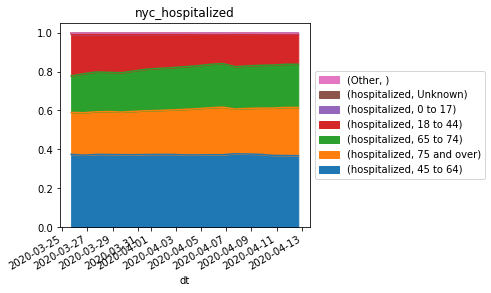

In [942]:
plotStackedLineNYC(nyc_data_hospitalized.drop('confirmed', 1), "nyc_hospitalized", 10, fromN=0, savefigName='nyc.hospitalized.total.png')



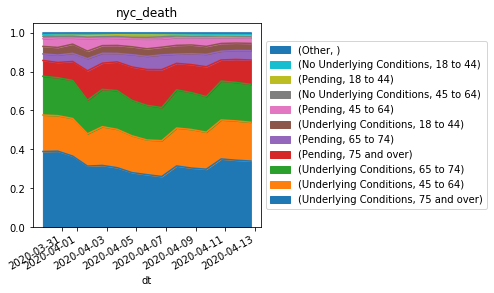

In [943]:
# grouped = nyc_data_death[nyc_data_death['first'] == 'Age Group'].reset_index().groupby(['dt','second']).sum().unstack().fillna(0)
plotStackedLineNYC(nyc_data_death.drop('Total', 1), "nyc_death", 10, fromN=0, savefigName='nyc.death.total.png')



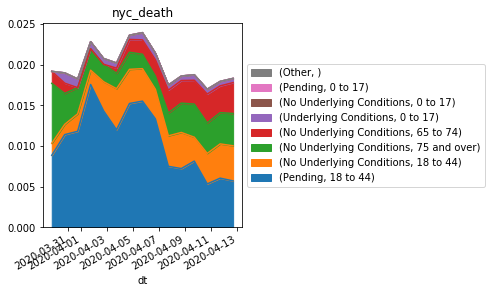

In [944]:
# grouped = nyc_data_death[nyc_data_death['first'] == 'Age Group'].reset_index().groupby(['dt','second']).sum().unstack().fillna(0)
plotStackedLineNYC(nyc_data_death.drop('Total', 1), "nyc_death", 15, fromN=8, savefigName='nounderlying.nyc.death.png')



In [945]:
ny_data = getStateData(all_data, "New York")[4:]

In [946]:
louisiana_data = getStateData(all_data, "Louisiana")[4:]

In [947]:
df_confirmed, df_confirmed_all = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_dead, df_dead_all = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_recovered, df_recovered_all = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


In [948]:
startdatetime = df_confirmed.index[0]
today = df_confirmed.index[-1]

In [949]:
df_active = df_confirmed.copy()
for col in df_confirmed.columns:
    df_active[col] = df_confirmed[col] - df_dead[col] - df_recovered[col]
df_active_all = df_confirmed_all.copy()
for col in df_confirmed_all.drop('Province/State', 1).drop('Country/Region',1).columns:
    df_active_all[col] = df_confirmed_all[col] - df_dead_all[col] - df_recovered_all[col]

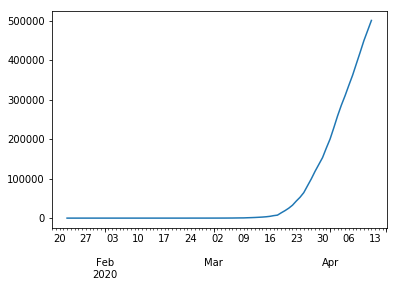

In [950]:
df_active.index = pd.to_datetime(df_active.index)
df_active['US'].plot()

In [951]:
mapping = {
    'Iran (Islamic Republic of)': 'Iran',
    'Korea, South': 'South Korea',
    'Russian Federation': 'Russia',
    'occupied Palestinian territory': 'Palestine',
    'Republic of Moldova': 'Moldova',
    'Macao SAR': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Saint Martin': 'St. Martin',
    'Taipei and environs': 'Taiwan',
    'Holy See': 'Vatican City',
    'Viet Nam': 'Vietnam',
}

#Mainland China

for countryName, oldCountryName in mapping.items():
    if oldCountryName in df_confirmed.columns and countryName in df_confirmed.columns:
        df_confirmed[countryName] += df_confirmed[oldCountryName]
        df_confirmed = df_confirmed.drop(oldCountryName, 1)
        
        df_death[countryName] += df_death[oldCountryName]
        df_death = df_death.drop(oldCountryName, 1)
        
        df_recovered[countryName] += df_recovered[oldCountryName]
        df_recovered = df_recovered.drop(oldCountryName, 1)
    
    if oldCountryName in population['Name'].values:
        population.loc[population['Name']==oldCountryName,'Name'] = countryName

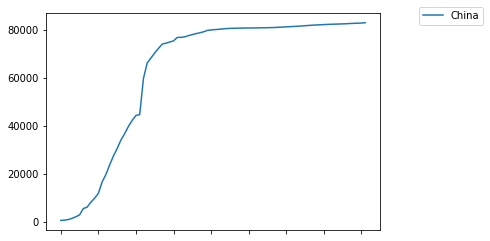

In [952]:
china = df_confirmed['China']
ax = china.plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

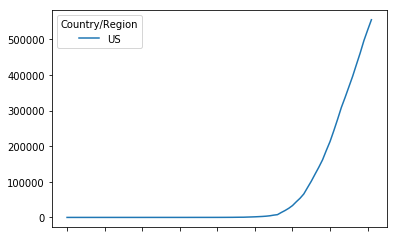

In [953]:
US = df_confirmed[['US']]
US.plot()

In [954]:
def generateAndPlotPrediction(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return lambda t: popt[0] * numpy.exp(popt[1] * t)
def generateAndPlotPredictionEstimates(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return popt

In [955]:
def addToAx(df, ax, dataFor, moredays=0, withFit=True, fromCaseNum=0, color='b'):
    df_from_case_num = df[df > fromCaseNum]
    x = np.linspace(1, len(df_from_case_num), len(df_from_case_num))
    y = df_from_case_num.values
    f = generateAndPlotPrediction(x, y)
    x2 = np.linspace(1, len(df_from_case_num) + moredays, len(df_from_case_num) + moredays)
    ax.plot(x, y, color + '-', label='data for {}'.format(dataFor))
    if withFit:
        print(dataFor, np.ceil(f(x2))[-1])
        ax.plot(x2, np.ceil(f(x2)), color + '--', label='fit for {}'.format(dataFor))
def plotCountries(df, start, end, savefilename='', moredays=0, logy=False, titlePH='confirmed', withFit=True, fromCaseNum=0):
    fig = plt.figure()
    ax = plt.subplot(111)
    for i, countryName in enumerate(df.T[start:end].T.columns):
        if countryName == 'Others':
            continue
        addToAx(df[countryName], ax, countryName, moredays=moredays, withFit=withFit, fromCaseNum=fromCaseNum, color=basic_colors[i])
    if moredays > 0:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases -- {} day prediction'.format(titlePH, fromCaseNum, moredays))
    else:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases'.format(titlePH, fromCaseNum))

    if logy:
        ax.set_yscale('log')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if savefilename:
        plt.savefig(savefilename, bbox_extra_artists=(lgd,), bbox_inches='tight')
def plotState(df, stateName, savefig='', moredays=0, withFit=True, fromCaseNum=0, logy=False):
    stateDf = df[
        df['Province/State'].str.contains(stateName)
    ].set_index('Province/State').T.sum(axis=1).T
    fig = plt.figure()
    ax = plt.subplot(111)
    addToAx(
        stateDf, 
        ax,
        stateName,
        moredays=moredays, 
        withFit=withFit, 
        fromCaseNum=fromCaseNum, 
        color=basic_colors[1]
    )
    if logy:
        ax.set_yscale('log')
    plt.title("{} Infected Num".format(stateName))
    plt.tight_layout()
    if savefig != '':
        plt.savefig(savefig, bbox_inches='tight')
def plotAllDataState(df, savefig='', moredays=0, withFit=True, fromCaseNum=0, logy=False):
    fig = plt.figure()
    ax = plt.subplot(111)
    for i, col in enumerate(["Confirmed", "Deaths"]):
        addToAx(
            df[col],
            ax,
            col,
            moredays=moredays, 
            withFit=withFit, 
            fromCaseNum=fromCaseNum, 
            color=basic_colors[i]
        )
    if logy:
        ax.set_yscale('log')
    plt.tight_layout()
    if savefig != '':
        plt.savefig(savefig, bbox_inches='tight')
def plotCountryDelta(df, countryName, nDaysRolling=3, logy=False, savefilename=None):
    df = df[[countryName]]
    df.loc[:,'delta'] = df[countryName].diff()
    df['secondDiv'] = df['delta'].diff()
    df['derivIncreaseDecrease'] = df['delta'] / df['delta'].shift()
#     df['secondDerivIncreaseDecrease'] = df['secondDiv'] / df['secondDiv'].shift()
    df = df.iloc[2:]
    fig, ax = plt.subplots()
    to_plot = df
    try:
        to_plot.index = map(toDT, to_plot.index)
    except:
        pass
    to_plot[[countryName]].plot(ax=ax)
    to_plot.delta.rolling(nDaysRolling).mean().iloc[nDaysRolling:].plot(ax=ax)
    to_plot.secondDiv.rolling(nDaysRolling).mean().iloc[nDaysRolling:].plot(ax=ax)
    to_plot.derivIncreaseDecrease.plot(ax=ax, secondary_y=True, style='r--')
#     to_plot.secondDerivIncreaseDecrease.plot(ax=ax, secondary_y=True, style='k--')
    if logy:
        ax.set_yscale('log')
        
    # Shrink current axis by 30%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])

    ax.set_ylabel('Number')
    ax.right_ax.set_ylabel('Increasing Or Decreasing Deriv')
    fig.get_axes()[1].set_ylim(0.8, 2.5)
    
    # Put a legend to the right of the current axis
    lines = ax.get_lines() + ax.right_ax.get_lines()
    lgd = ax.legend(lines, [l.get_label() for l in lines], loc='center left', bbox_to_anchor=(1.15, 0.5))
    plt.title('Plotting Change For ' + countryName)
    plt.tight_layout()
    if savefilename:
        plt.savefig(savefilename, bbox_extra_artists=(lgd,), bbox_inches='tight')
        


In [956]:
def plot_state2(stateName, savefig=''):
    state_data = getStateData(all_data, stateName)[4:]
    state_data_to_plot = state_data[['Confirmed', 'Deaths']]
    state_data_to_plot.loc[:, 'delta_confirmed'] = state_data_to_plot['Confirmed'] - state_data_to_plot['Confirmed'].shift()
    state_data_to_plot.loc[:, 'delta_deaths'] = state_data_to_plot['Deaths'] - state_data_to_plot['Deaths'].shift()
    state_data_to_plot = state_data_to_plot.iloc[1:]
    state_data_to_plot.loc[:, 'doubling_confirmed_days'] = np.log(2)/np.log(1+state_data_to_plot['delta_confirmed']/(state_data_to_plot['Confirmed'] - state_data_to_plot['delta_confirmed']))
    state_data_to_plot.loc[:, 'doubling_deaths_days'] = np.log(2)/np.log(1+state_data_to_plot['delta_deaths']/(state_data_to_plot['Deaths'] - state_data_to_plot['delta_deaths']))
    plotting = state_data_to_plot[['doubling_confirmed_days', 'doubling_deaths_days']]
    print(plotting.iloc[-1], "\n", plotting.iloc[-7])
    plotting.rolling(3).mean().plot()
    plt.title(stateName + ' Expected Days To Double')
    if savefig:
        plt.savefig(savefig + ".png")


doubling_confirmed_days    16.015069
doubling_deaths_days        8.230602
Name: 2020-04-12 00:00:00, dtype: float64 
 doubling_confirmed_days    10.206083
doubling_deaths_days        5.687958
Name: 2020-04-06 00:00:00, dtype: float64


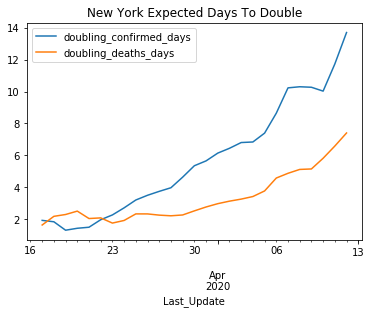

In [957]:
plot_state2("New York", savefig='ny.days.to.double')

Confirmed 376452.0
Deaths 24713.0


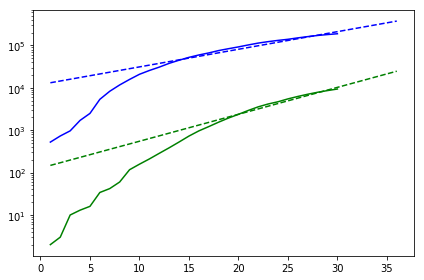

In [969]:
plotAllDataState(ny_data, moredays=6, logy=True)

US 615149.0


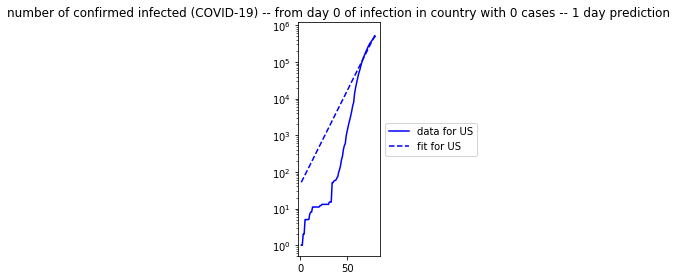

In [824]:
plotCountries(df_confirmed.T.iloc[[0]].T, 0, 1, moredays=1, logy=True)

US 546567.0
Spain 184738.0
Italy 172586.0
Germany 140868.0


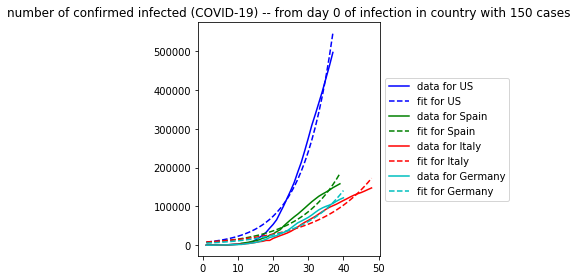

In [827]:
plotCountries(df_confirmed.T.iloc[[0, 1, 2, 4, 5]].T, 0, 4, 
              'Italy.Germany.US.Spain.png',
              moredays=0, 
              logy=False, 
              fromCaseNum=150)

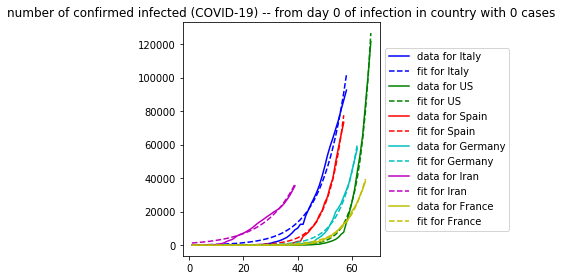

In [1579]:
plotCountries(df_confirmed, 1,7, logy=False, fromCaseNum=0)

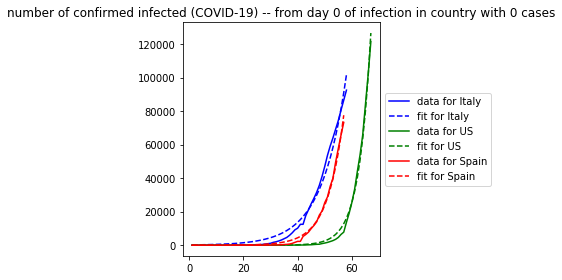

In [1580]:
plotCountries(df_confirmed, 1,4, 'SK.Iran.Italy.png',moredays=0)

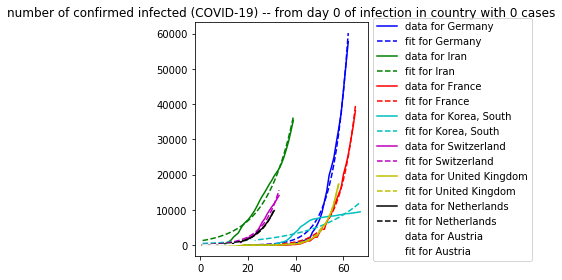

In [1581]:
plotCountries(df_confirmed, 4,len(basic_colors) + 4, '4.11.png', moredays=0)

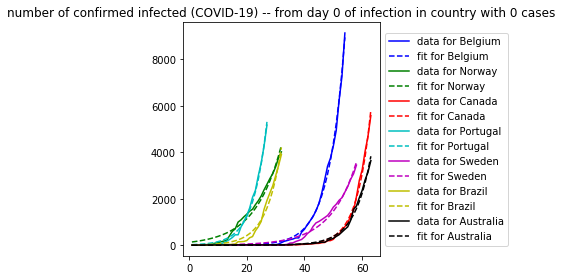

In [1582]:
plotCountries(df_confirmed, len(basic_colors) + 4, 2*len(basic_colors) + 3, '12.18.png', moredays=0)

In [828]:
US_all_confirmed = df_confirmed_all[df_confirmed_all['Country/Region'] == 'US']
US_all_confirmed = US_all_confirmed.drop('Country/Region', 1)

US_all_dead = df_dead_all[df_confirmed_all['Country/Region'] == 'US']
US_all_dead = US_all_dead.drop('Country/Region', 1)

US_all_active = df_active_all[df_confirmed_all['Country/Region'] == 'US']
US_all_active = US_all_active.drop('Country/Region', 1)

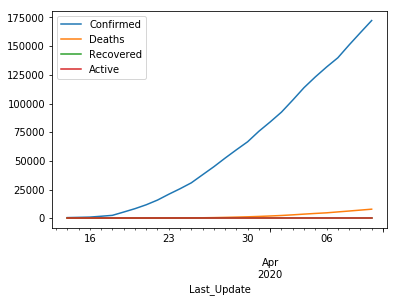

In [829]:
ny_data.plot()

Timestamp('2020-04-10 00:00:00')

In [970]:
dfByPop = pd.merge(df_active.iloc[-1:].T.reset_index().rename(columns={'Country/Region':'Name'}), population, on='Name')
dfByPop = dfByPop.rename(columns={df_active.index[-1]:'InfectedNum'})
# dfByPop['Population'] = dfByPop['Population'].str.replace(",","").astype(int)
dfByPop['1 in X'] = (dfByPop['Population'] / dfByPop['InfectedNum']).replace([np.inf, -np.inf], np.nan).dropna(how="all").astype(int)
dfByPop['% Have It'] = (100 * dfByPop['InfectedNum'] / dfByPop['Population']).round(4)

success
                    Name  InfectedNum  1 in X
0                  Spain        87231     535
1                  Italy       102253     591
2                Belgium        19584     591
3               Portugal        15804     645
4                     US       500305     661
5                 France        91789     711
6            Switzerland        11609     745
7            Netherlands        22704     754
8                 Norway         6365     851
9         United Kingdom        73951     917
10                Israel         9415     919
11                Sweden         9203    1097
12               Germany        64532    1298
13               Austria         6608    1362
14               Denmark         3805    1522
15                Turkey        52312    1612
16               Finland         2618    2116
17                Canada        16461    2292
18                Serbia         3550    2461
19               Ecuador         6632    2660
20  United Arab Emirates  

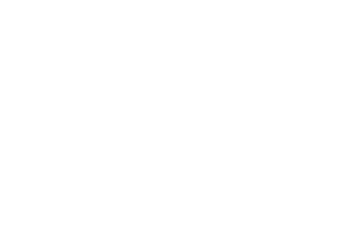

In [971]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tableToPlot = dfByPop[dfByPop['Population'] > 5000000].sort_values(by='1 in X').reset_index()[['Name', 'InfectedNum', '1 in X']]

tableToPlot[:25].to_html('table.tmp.html')
title = """<h3>Active Cases By Country, 1 In X people currently have it</h3>"""
with open('table.tmp.html', 'r') as f:
    with open('table.html', 'w') as f2:
        f2.write(title + "\n")
        f2.write(f.read())
import subprocess
output = subprocess.call(
    'wkhtmltoimage -f png --width 0 table.html table.activebycountry.1inx.wkh.png', shell=True)

if output != 0:
    print("Try installing wkhtmltoimage/pdf: brew cask install wkhtmltopdf")
else:
    subprocess.call('rm *.html', shell=True)
    print("success")
    print(tableToPlot[:25])

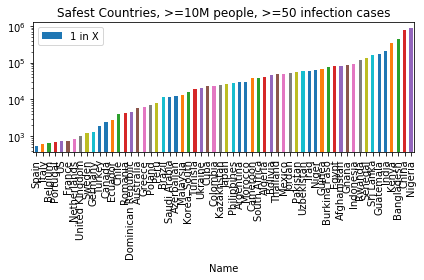

In [847]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].plot.bar(x='Name', y='1 in X',logy=True)
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.1inx.png', bbox_inches='tight')

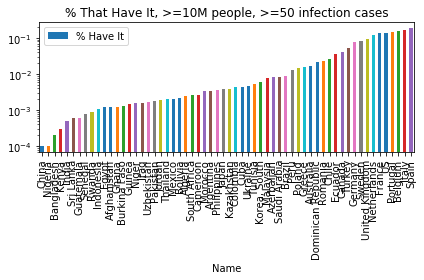

In [848]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='% Have It')
toPlot[['Name', '% Have It']].plot.bar(x='Name', y='% Have It',logy=True)
plt.title('% That Have It, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.percenthaveit.png', bbox_inches='tight')

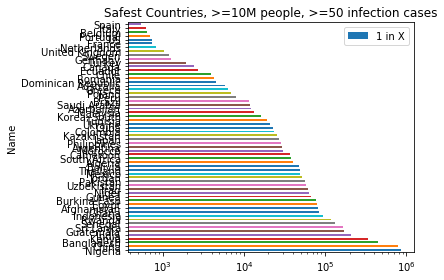

In [849]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].iloc[::-1].plot(kind='barh', x='Name', y='1 in X', logx=True)
ax.invert_xaxis()
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.2.png')

In [850]:
notChina = df_confirmed.drop('China', 1)
notChina = pd.DataFrame(data=notChina.sum(axis=1).values, columns=['NumInfected'], index=notChina.index)
notChina['delta'] = notChina.diff(axis=0)
notChina = notChina.iloc[1:]
notChina['secondDiv'] = notChina['delta'] / notChina['delta'].shift()
notChina = notChina.iloc[1:]

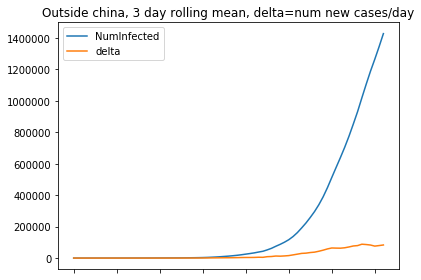

In [851]:
notChina[['NumInfected','delta']].rolling(3).mean().iloc[4:-1].plot()
plt.title("Outside china, 3 day rolling mean, delta=num new cases/day")
plt.tight_layout()
plt.savefig("outsidechina.firstderiv.png")

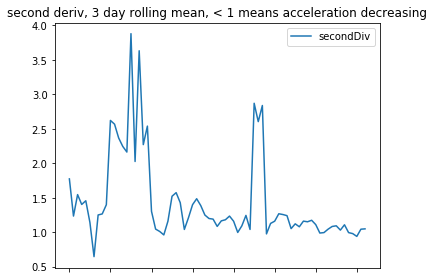

In [852]:
notChina[['secondDiv']].rolling(3).mean().iloc[4:-1].plot()
plt.title("second deriv, 3 day rolling mean, < 1 means acceleration decreasing")
plt.tight_layout()
# plt.savefig("outsidechina.secondderiv.png")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


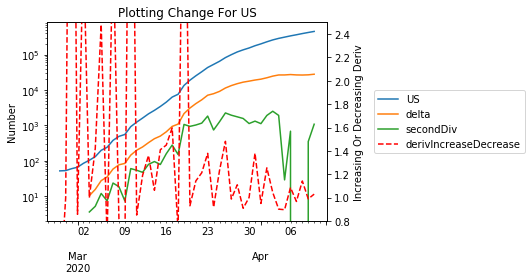

In [853]:
plotCountryDelta(df_active.iloc[34:], 'US', logy=True, nDaysRolling=5, savefilename='USChange.png')

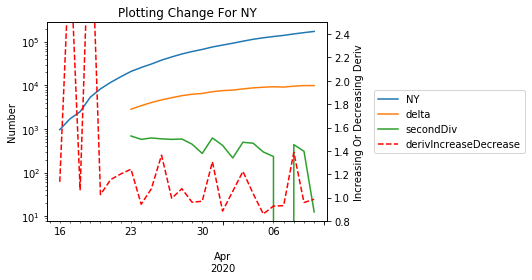

In [854]:
tmp = df_active.copy() # ny_data['Confirmed']
tmp = tmp.join(ny_data['Confirmed'])[['Confirmed']].dropna().rename(columns={'Confirmed':'NY'})
plotCountryDelta(tmp, 'NY', logy=True, nDaysRolling=7)#, #savefilename='USChange.png')

In [855]:
def predictForwardFromOthers(df, currentVal, inHowManyDays):
    avgT = 0
    avgC = 0
    for countryName in df.iloc[-1:][df.iloc[-1:] > currentVal].dropna(1).columns:
        if 'China' in countryName:
            continue
        previousValue = sum(df[countryName] > currentVal) + 1
        dfIncluding = df[countryName][-previousValue:]
        if (previousValue - 1) < inHowManyDays:
            continue
        previous, nextVal = dfIncluding.iloc[0], dfIncluding.iloc[inHowManyDays]
        avgT += (1 - (currentVal - previous)/currentVal) * (nextVal - currentVal)
        avgC += 1
    return avgT/avgC + currentVal, avgC

In [856]:
predictForwardFromOthers(df_dead, 2200, 4) # new york numbe rof cases

(3741.315303030303, 6)

In [1218]:
predictForwardFromOthers(df_confirmed, 328, 4)

(767.5867729831144, 26)

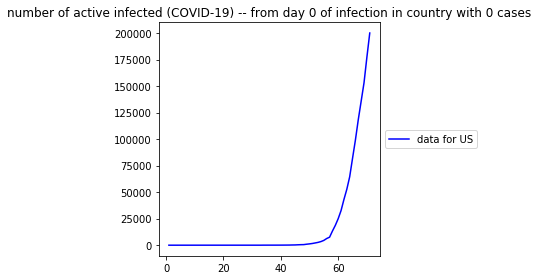

In [230]:
plotCountries(df_active, 0, 1, titlePH='active',withFit=False, savefilename='activeCasesChina.png')

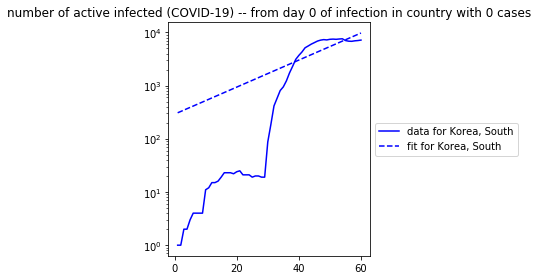

In [1220]:
plotCountries(df_active, 7, 8, titlePH='active',withFit=True, logy=True, savefilename='us_active_logy.png')

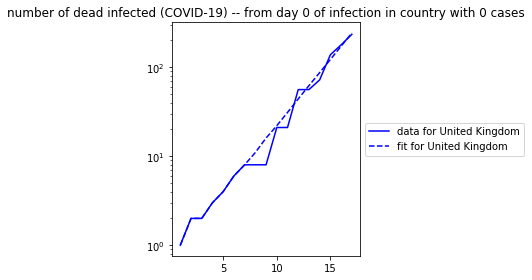

In [1221]:
plotCountries(df_dead, 6, 7, titlePH='dead',withFit=True, logy=True, savefilename='us_dead_logy.png')

In [864]:
def plotStackedLine(df, title, numberOfCountries, savefigName=''):
    percentActiveDf =  df.div(df.sum(1), axis=0)
    plottingDf = percentActiveDf.T.sort_values(by=df_active.index[-1],ascending=False).iloc[:numberOfCountries].T
    if 'China' not in plottingDf:
        plottingDf['China'] = percentActiveDf['China']
    plottingDf['Other'] = 1 - plottingDf.sum(axis=1)
    plottingDf.index = list(map(toDT, plottingDf.index))

    ax = plottingDf.plot.area()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.title(title)

    if savefigName:
        plt.savefig(savefigName, bbox_extra_artists=(lgd,), bbox_inches='tight')

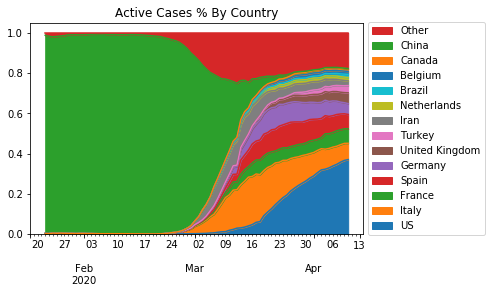

In [865]:
plotStackedLine(df_active, 'Active Cases % By Country', 12, 'stackedarea.active.all.png')

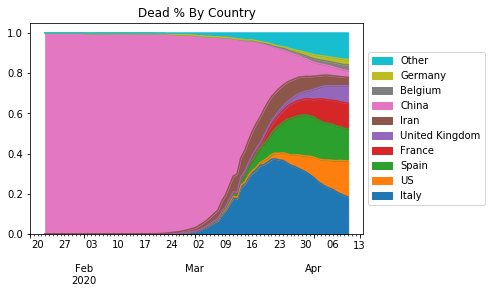

In [872]:
plotStackedLine(df_dead, 'Dead % By Country', 9, 'stackedarea.dead.all.png')

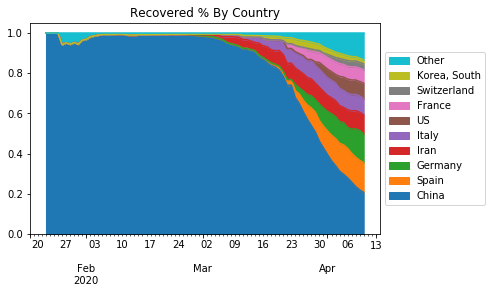

In [875]:
plotStackedLine(df_recovered, 'Recovered % By Country', 9, 'stackedarea.recovered.all.png')

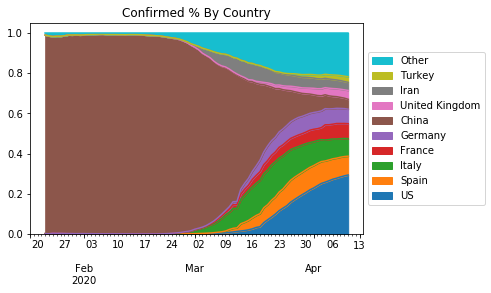

In [877]:
plotStackedLine(df_confirmed, 'Confirmed % By Country', 9, 'stackedarea.recovered.all.png')

In [878]:
italy = df_dead[['Italy']].rename(columns={'Italy':'Cum Num Dead'})
italy['new_dead'] = italy['Cum Num Dead'] - italy['Cum Num Dead'].shift(1)
italy['dead_per_minute'] = (24 * 60) / italy['new_dead']
italy = italy.iloc[1:].replace(np.inf, 0)

There is one death per 151.57894736842104 seconds in the Italy right now


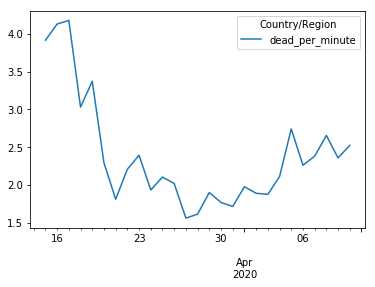

In [894]:
print("There is one death per {} seconds in the Italy right now".format(italy['dead_per_minute'].iloc[-1] * 60))
italy[['dead_per_minute']][italy['dead_per_minute']!=0].iloc[22:].plot()
plt.savefig('italy.deaths.per.minute.png')

In [882]:
lastTwoDaysDeaths = df_dead.sum(axis=1).iloc[-2:]
secondsPerDeaths = int((24*60*60)/(lastTwoDaysDeaths.iloc[-1] - lastTwoDaysDeaths.iloc[0]))
print("There is one death per {} seconds in the world right now".format(secondsPerDeaths))

There is one death per 12 seconds in the world right now


There is one death per 40.98671726755218 seconds in the US right now


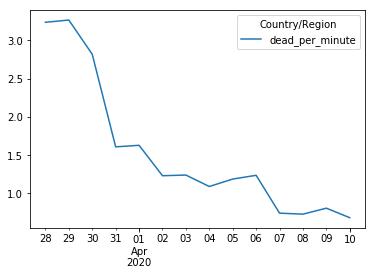

In [902]:
US = df_dead[['US']].rename(columns={'US':'Cum Num Dead'})
US['new_dead'] = US['Cum Num Dead'] - US['Cum Num Dead'].shift(1)
US['dead_per_minute'] = (24 * 60) / US['new_dead']
US = US.iloc[1:].replace(np.inf, 0)
print("There is one death per {} seconds in the US right now".format(US['dead_per_minute'].iloc[-1] * 60))
US[['dead_per_minute']][US['dead_per_minute']!=0].iloc[27:].plot()

In [1427]:
def combineCountry(df_dead, df_confirmed, df_active, df_recovered, countryName):
    if df_dead is not None:
        df_dead = df_dead[[countryName]].rename(columns={countryName:countryName + " Dead"})
    if df_confirmed is not None:
        df_confirmed = df_confirmed[[countryName]].rename(columns={countryName:countryName + " Confirmed"})
    if df_active is not None:
        df_active = df_active[[countryName]].rename(columns={countryName:countryName + " Active"})
    if df_recovered is not None:
        df_recovered = df_recovered[[countryName]].rename(columns={countryName:countryName + " Recovered"})    
    
    dfs = list(filter(lambda x: x is not None, [df_dead, df_confirmed, df_active, df_recovered]))
    if len(dfs) == 0:
        return None
    df = dfs[0]
    for df2 in dfs[1:]:
        df = df.join(df2)
    return df

In [1428]:
def plotCountriesTotal(df_dead, df_confirmed, df_active, df_recovered, countryNames):
    fig = plt.figure()
    ax = plt.subplot(111)
    for countryName in countryNames:
        df = combineCountry(df_dead, df_confirmed, df_active, df_recovered, countryName)
        df.index = list(map(toDT, df.index))
        df.plot(ax=ax)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.title(" - ".join(countryNames))
    plt.savefig(".".join(countryNames) + ".all.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

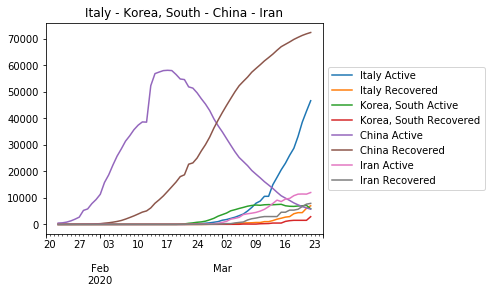

In [1429]:
plotCountriesTotal(None, None, df_active, df_recovered, ["Italy", "Korea, South", "China", "Iran"])

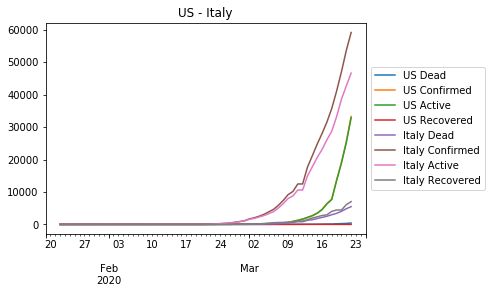

In [1430]:
plotCountriesTotal(df_dead, df_confirmed, df_active, df_recovered, ["US", "Italy"])

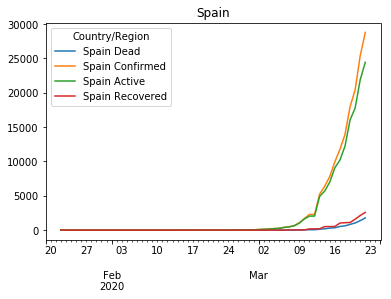

In [1431]:
plotCountryTotal(df_dead, df_confirmed, df_active, df_recovered, "Spain")

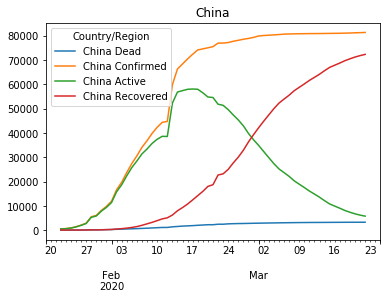

In [1432]:
plotCountryTotal(df_dead, df_confirmed, df_active, df_recovered, "China")

In [903]:
# https://link.springer.com/article/10.1007/s00134-012-2627-8/tables/2
ICUBeds = {
    "US": 34.2,
    "Germany": 29.2,
    "Italy": 12.5,
    "France": 11.6,
    "Korea, South": 10.6,
    "Spain": 9.7,
    "Japan": 7.3,
    "United Kingdom": 6.6,
    "China": 3.6,
    "India": 2.3,
    "Iran": 7.29,
    "Switzerland": 11.0,
    "Netherlands": 6.4,
    "Norway": 8.0,
    "Sweden": 5.8,
    "Belgium": 15.9,
    "Austria": 21.8,
    "Denmark": 6.7,
    "Andorra": 7.1,
    "Bulgaria": 12.2,
    
}
icuBeds = pd.DataFrame(data=[ICUBeds]).T.rename(columns={0:'ICU Beds Per 100k'})

In [912]:
todayDead = df_dead.iloc[[-1]].T.rename(columns={df_dead.index[-1]:"dead"})
todayConfirmed = df_confirmed.iloc[[-1]].T.rename(columns={df_dead.index[-1]:"confirmed"})
todayRecovered = df_recovered.iloc[[-1]].T.rename(columns={df_dead.index[-1]:"recovered"})
df = todayDead.join(todayConfirmed).join(todayRecovered)
df['death_rate'] = (100 * df['dead'] / df['confirmed']).round(2)
df['recover_rate'] = (100 * df['recovered'] / df['confirmed']).round(2)
df = df.join(careBeds.set_index("Country")[["ICU Beds Per 100k"]])

In [913]:
def scatterPlotICU(df, yaxis):
    toPlot = df.dropna().iloc[:len(colors)]
    toPlot['color'] = colors
    fig = plt.figure(figsize=(8,8),dpi=75)
    ax = fig.gca()
    ax.scatter(toPlot[yaxis],toPlot['ICU Beds Per 100k'],c=toPlot["color"],alpha=0.4)
    ax.set_xlabel(yaxis)
    ax.set_ylabel("ICU Beds Per 100k")

    col_dict = toPlot[['color']].to_dict()['color']

    #retrieve values from color dictionary and attribute it to corresponding labels
    leg_el = [
        mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) 
        for key, value in col_dict.items()
    ]
    lgd = ax.legend(handles = leg_el)
    plt.title("ICU Beds Versus " + yaxis)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    plt.tight_layout()
    plt.savefig("icu."+yaxis+".png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [919]:
df[df['confirmed'] > 1000].sort_values(by='death_rate',ascending=False)

,dead,confirmed,recovered,death_rate,recover_rate,ICU Beds Per 100k
Country/Region,,,,,,
Algeria,256,1761,405,14.54,23.00,NaN
Italy,18849,147577,30455,12.77,20.64,12.5
United Kingdom,8974,74605,588,12.03,0.79,3.8
Belgium,3019,26667,5568,11.32,20.88,15.9
Netherlands,2520,23249,287,10.84,1.23,NaN
France,13215,125931,25195,10.49,20.01,6.3
Spain,16081,158273,55668,10.16,35.17,9.7
Sweden,870,9685,381,8.98,3.93,5.8
Indonesia,306,3512,282,8.71,8.03,NaN


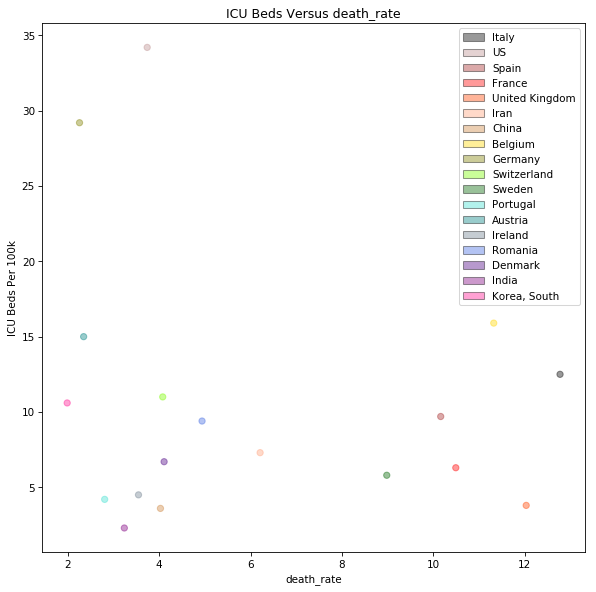

In [911]:
scatterPlotICU(df, "death_rate")

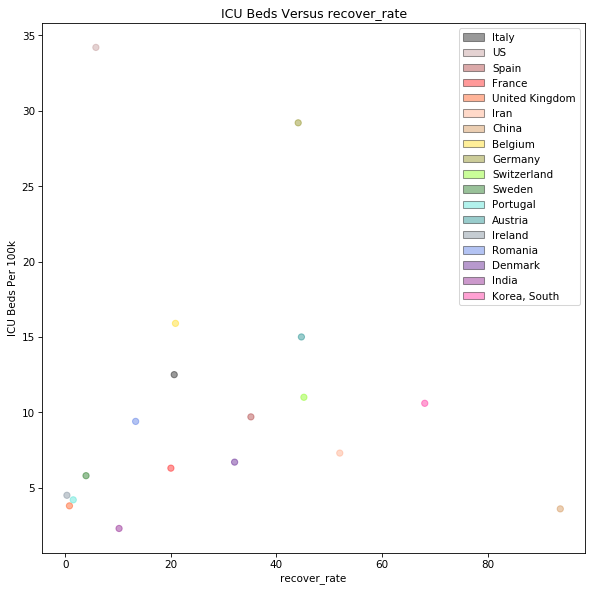

In [914]:
scatterPlotICU(df, "recover_rate")